Import PyTorch, create a tensor, and print it.

In [1]:
import torch

A = torch.randn(5,6)
print(A)

tensor([[-1.1382, -0.1980, -0.3497, -0.7018, -0.2475,  0.6165],
        [ 1.4513,  0.9746, -1.3507,  0.6127,  0.0873,  0.3350],
        [ 0.5387,  0.9310, -1.0898,  1.1849,  1.8658,  1.2108],
        [ 0.1336, -0.3363,  0.7776, -0.8287, -3.1402, -0.1449],
        [-0.4005, -0.2726, -0.5412,  0.4628,  0.5365,  0.8663]])


## Matrix Multiplication
### Functions
* `matmul`
* `mm`
* `@`

In [2]:
A = torch.randn(5, 6)
B = torch.randn(6, 2)

print(A.matmul(B))
print(A.mm(B))
print(A@B)

tensor([[ 2.1070, -1.9225],
        [-0.0373,  3.7989],
        [ 0.7761,  0.1420],
        [ 1.4358,  5.2266],
        [ 0.0899, -3.5014]])
tensor([[ 2.1070, -1.9225],
        [-0.0373,  3.7989],
        [ 0.7761,  0.1420],
        [ 1.4358,  5.2266],
        [ 0.0899, -3.5014]])
tensor([[ 2.1070, -1.9225],
        [-0.0373,  3.7989],
        [ 0.7761,  0.1420],
        [ 1.4358,  5.2266],
        [ 0.0899, -3.5014]])


## Distributions
e.g.) Bernoulli : $\text{Bernoulli}(p)$ where $p=0.8$.

`X` : the Bernoulli random variable   
`X.log_prob(torch.Tensor([1,0,0,1,1]))` : the log probability of the observations: `[1, 0, 0, 1, 1]`.

In [3]:
from torch.distributions.bernoulli import Bernoulli

X = Bernoulli(0.8)
print(X.log_prob(torch.Tensor([1,0,0,1,1])))

tensor([-0.2231, -1.6094, -1.6094, -0.2231, -0.2231])


## Matrix Operations
Let $X\in \mathbb R^{m\times n}$ be a data matrix of $m$ samples with $n$ features. Implement the batched sample gradient, $\nabla_X f(X)$, for each of the calculus problems from the written homework. The batched sample gradient is the $m\times n$ matrix where the $i$th row is the gradient of $f$ with respect to the $i$th sample.

Do so using matrix operations without any for loops. As an example, the first one has been done for you.

Some variables other than $X$ can also be batched, such as sample labels $Y \in \mathbb R^{m}$. For such functions, the $i$th sample gradient of these examples is taken with respect to the sample $x_i$ using the sample label $y_i$: $\nabla_{x_i} f(x_i,y_i)$.


1. $f(x_i;w) = w^\top x_i$
2. $f(x_i) = x_i^\top x_i$
3. $f(x_i,y_i;w) = (y_i-w^\top x_i)^2$
4. $f(x_i,y_i;w) = \log(1 + \exp(-y_iw^\top x_i))$
5. $f(x_i;A) = x_i^\top Ax_i$ where $A\in\mathbb{R}^{n\times n}$

In [144]:
def grad1(X, w):
  return w.repeat(X.size(0), 1)

def grad2(X):
  return X * 2

def grad3(X, y, w):
  y, w = y.unsqueeze(1), w.unsqueeze(1)
  return -2 * (y - X @ w) @ (w.T)

def grad4(X, y, w):
  y, w = y.unsqueeze(1), w.unsqueeze(1)
  E = torch.exp(-y * (X @ w))   # m x 1
  return -((E/(1+E)) * y) @ (w.T)

def grad5(X, A):
  return X @ (A + A.T)

Test

`f1_sum` : $\sum_i f(x_i; w) = \sum_i w^\top x_i$   
`f2_sum` : $\sum_i f(x_i) = \sum_i x_i^\top x_i$   
`f3_sum` : $\sum_i f(x_i, y_i; w) = \sum_i (y_i - w^\top x_i)^2$   
`f4_sum` : $\sum_i f(x_i, y_i; w) = \sum_i \log{(1+\exp{(-y_i w^\top x_i)})}$   
`f5_sum` : $\sum_i f(x_i; w) = \sum_i x_i^\top A x_i$   

In [145]:
def f1_sum(X, w):
    # 각 샘플별 f(x_i; w) = w^T x_i
    # 모든 샘플 합: sum_i (w^T x_i) = sum( X @ w )
    return torch.sum(X @ w)

def f2_sum(X):
    # 각 샘플별 f(x_i) = x_i^T x_i
    # 모든 샘플 합: sum_i ||x_i||^2 = sum(X * X)
    return torch.sum(X * X)

def f3_sum(X, y, w):
    # 각 샘플별 f(x_i, y_i; w) = (y_i - w^T x_i)^2
    # 모든 샘플 합
    Xw = X @ w
    yXw = y - (Xw)
    return torch.sum(yXw * yXw)

def f4_sum(X, y, w):
    # 각 샘플별 f(x_i, y_i; w) = log(1 + exp(-y_i * w^T x_i))
    # 모든 샘플 합
    return torch.sum(torch.log(1.0 + torch.exp(-y * (X @ w))))

def f5_sum(X, A):
    # 각 샘플별 f(x_i; A) = x_i^T A x_i
    # 모든 샘플 합
    # 방법 1) 직접 곱
    return torch.sum((X @ A) * X)
    #  (X @ A)[i] = A x_i,  요소별 곱 후 sum하면 x_i^T A x_i

In [146]:
def check_grad(f_sum, grad_fn, X, y=None, w=None, A=None, tol=1e-6, name=""):
    """
    f_sum: 실제 스칼라로 만들어주는 함수 (예: f1_sum, f2_sum, ...)
    grad_fn: 문제에서 구현한 해석적 gradient 함수 (grad1, grad2, ...)
    X, w, y, A: 입력 텐서들
    """
    # X에 대한 gradient 확인을 위해 복사본에 requires_grad_(True)
    X_ = X.clone().detach().requires_grad_(True)

    # w, A 도 X와 마찬가지로 autograd 비교가 필요하면 requires_grad_(True) 해도 되지만
    # 여기서는 X에 대한 gradient만 비교한다 가정
    w_ = w.clone().detach() if w is not None else None
    y_ = y.clone().detach() if y is not None else None
    A_ = A.clone().detach() if A is not None else None

    # 스칼라 함수 f(X_, w_, y_, A_) 계산
    # None인 인자는 넘기지 않도록 처리
    args = [arg for arg in [X_, y_, w_, A_] if arg is not None]
    out = f_sum(*args)  # 예) f1_sum(X_, w_)

    # backward로 X_에 대한 gradient 획득
    out.backward()
    grad_auto = X_.grad  # autograd로 구한 gradient

    # 우리가 만든 해석적 gradient
    if name.startswith("grad5"):
        # grad5는 A도 필요
        grad_ours = grad_fn(X_, A_)
    elif name.startswith("grad4"):
        grad_ours = grad_fn(X_, y_, w_)
    elif name.startswith("grad3"):
        grad_ours = grad_fn(X_, y_, w_)
    elif name.startswith("grad2"):
        grad_ours = grad_fn(X_)
    else:
        # grad1
        grad_ours = grad_fn(X_, w_)

    # 실제로 비교
    diff = (grad_auto - grad_ours).abs().max().item()
    result = f"[{name}] max diff: {diff:.6g}"
    if diff < tol:
        result += " -> OK"
    else:
        result += " -> NOT OK"
    print(result)

In [147]:
import torch

def test_question1():
    torch.manual_seed(0)
    m, n = 5, 3
    X = torch.randn(m, n)
    w = torch.randn(n)
    y = torch.randn(m)
    A = torch.randn(n, n)

    # grad1 테스트
    check_grad(
        f_sum=f1_sum,
        grad_fn=grad1,
        X=X, w=w,
        name="grad1"
    )

    # grad2 테스트
    check_grad(
        f_sum=f2_sum,
        grad_fn=grad2,
        X=X,
        name="grad2"
    )

    # grad3 테스트
    check_grad(
        f_sum=f3_sum,
        grad_fn=grad3,
        X=X, y=y, w=w,
        name="grad3"
    )

    # grad4 테스트
    check_grad(
        f_sum=f4_sum,
        grad_fn=grad4,
        X=X, y=y, w=w,
        name="grad4"
    )

    # grad5 테스트
    check_grad(
        f_sum=f5_sum,
        grad_fn=grad5,
        X=X, A=A,
        name="grad5"
    )

if __name__ == '__main__':
  test_question1()

[grad1] max diff: 0 -> OK
[grad2] max diff: 0 -> OK
[grad3] max diff: 0 -> OK
[grad4] max diff: 1.49012e-08 -> OK
[grad5] max diff: 2.38419e-07 -> OK


# Dataset statistics

Let $X\in \mathbb R^{m\times n}$ be a data matrix of $m$ samples with dimension
$n$. Implement the following functions to calculate dataset statistics:

1. Calculate the mean of each feature using the unbiased sample mean
2. Calculate the variance of each feature using the unbiased sample variance
3. Normalize the data matrix to have zero mean and unit variance along each feature.

In [167]:
def stat1(X):
  return torch.sum(X, 0) / X.size(0)

def stat2(X):
  m = X.size(0)
  mean_rep = stat1(X).repeat(m, 1)
  return torch.sum((X-mean_rep)**2, 0) / (m-1)

def stat3(X):
  mean_rep = stat1(X).repeat(m, 1)
  std_dev = stat2(X) ** .5
  return (X-mean_rep) / std_dev

Test Code

In [168]:
def f1_stat(X):
  return X.mean(dim=0)

def f2_stat(X):
  return X.var(dim=0, unbiased=True)

def f3_stat(X):
  m = X.size(0)
  mean_rep = X.mean(dim=0).repeat(m, 1)
  std_dev_rep = (X.var(dim=0, unbiased=True) ** .5).repeat(m, 1)
  return (X -mean_rep) / std_dev_rep

def check_stat(stat_func, f_stat_func, X, tol):
  diff_sum = torch.sum(stat_func(X) - f_stat_func(X))
  diff = (diff_sum).abs().max().item()
  result = f"[{stat_func.__name__}] max diff: {diff:.6g}"
  if diff < tol:
      result += " -> OK"
  else:
      result += " -> NOT OK"
  print(result)


if __name__ == '__main__':
    torch.manual_seed(0)
    m, n = 5, 3
    X = torch.randn(m, n)
    tol=1e-6

    check_stat(stat1, f1_stat, X, tol)
    check_stat(stat2, f2_stat, X, tol)
    check_stat(stat3, f3_stat, X, tol)

[stat1] max diff: 0 -> OK
[stat2] max diff: 1.19209e-07 -> OK
[stat3] max diff: 2.98023e-08 -> OK


# Sampling and plotting

Draw samples from a 2D multivariate Gaussian with mean $\mu=[-1,2]$ and covariance matrix $\Sigma=\left[\begin{array}{cc} 1 & 2 \\ 2 & 5\end{array}\right]$.

Then, plot this data using matplotlib. The plotting is not autograded, but you can compare your result with the image at the end of this notebook.

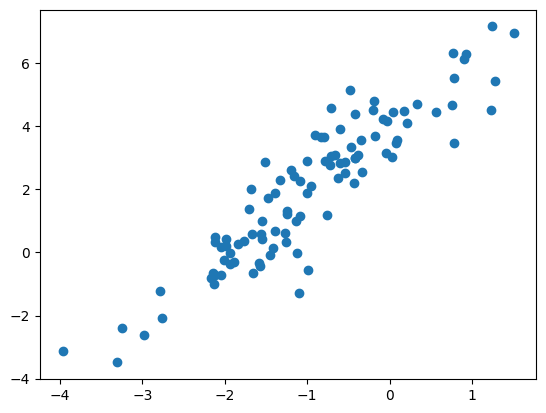

In [176]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal

def sample(n):
    # Draw samples from a 2D Gaussian with the given parameters. The ith row of
    # the output should have a drawn sample.
    # Return := Tensor of size (n,2)
    mean = torch.tensor([-1., 2.])
    covariance = torch.tensor([[1.,2.], [2.,5.]])
    m = MultivariateNormal(mean, covariance)
    return m.sample((n,))

def plot(X):
    # Plot data from the given matrix. Each row in X is a data point with 2
    # features to be plotted.
    # X := Tensor of size (m,2)
    plt.scatter(X[:, 0], X[:, 1])  # Use scatter plot for 2D points
    plt.show()

if __name__ == '__main__':
    n = 100
    sample = sample(n)
    # print(sample)
    plot(sample)